In [1]:
%conda info


     active environment : dl38
    active env location : /opt/conda/envs/dl38
            shell level : 1
       user config file : /opt/ml/.condarc
 populated config files : 
          conda version : 4.10.1
    conda-build version : 3.18.11
         python version : 3.7.7.final.0
       virtual packages : __cuda=10.1=0
                          __linux=4.4.0=0
                          __glibc=2.27=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /opt/conda  (writable)
      conda av data dir : /opt/conda/etc/conda
  conda av metadata url : https://repo.anaconda.com/pkgs/main
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /opt/conda/pkgs
                          /opt/ml/.c

# EDA

## Overview

### 개요

"한국에서 가장 오래된 나무는 무엇일까?" 이런 궁금한 질문이 있을 때 검색엔진에 가서 물어보신 적이 있을텐데요, 요즘엔 특히나 놀랍도록 정확한 답변을 주기도 합니다. 어떻게 가능한 걸까요?

질의 응답(Question Answering)은 다양한 종류의 질문에 대해 대답하는 인공지능을 만드는 연구 분야입니다. 그 중에서도 Open-Domain Question Answering 은 주어지는 지문이 따로 존재하지 않고 사전에 구축되어있는 knowledge resource 에서 질문에 대답할 수 있는 문서를 찾는 과정이 추가가 되어야하기에 더 어려운 문제입니다.

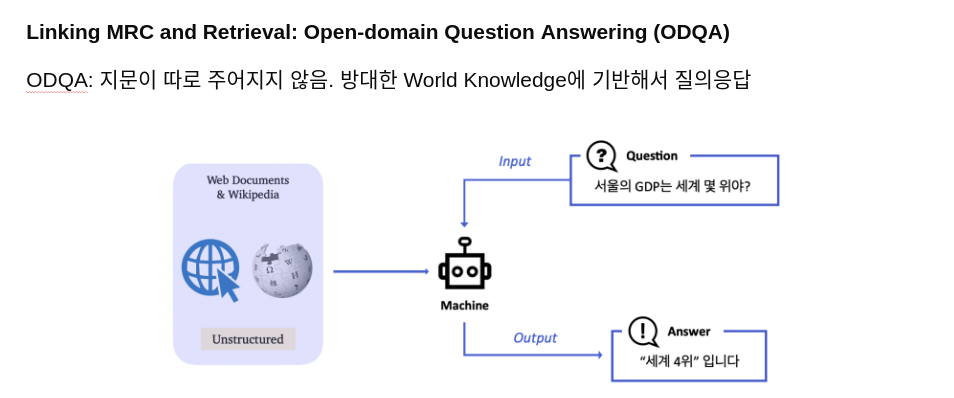

본 대회에서 우리가 만들 모델은 두 stage로 구성되어 있습니다. 첫 번째 단계는 질문에 관련된 문서를 찾아주는 "retriever"단계이고요, 다음으로는 관련된 문서를 읽고 간결한 답변을 내보내 주는 "reader" 단계입니다. 이 두 단계를 각각 만든 뒤 둘을 이으면, 어려운 질문을 던져도 척척 답변을 해주는 질의응답 시스템을 여러분 손으로 직접 만들게 됩니다. 더 정확한 답변을 내주는 모델을 만드는 팀이 우승을 하게 됩니다.

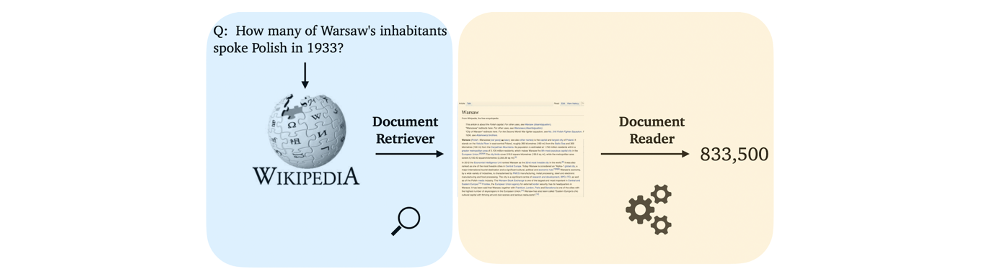

### evaluation metics

평가방법은 두가지입니다.

1. Exact Match (EM): 
    - 모델의 예측과, 실제 답이 정확하게 일치할 때만 점수가 주어집니다. 즉 각 질문마다 0점 아니면 1점입니다. 다만 띄어쓰기나 "."과 같은 문자가 포함돼 있다고 오답으로 처리되면 억울하겠죠? 이런 것은 지우고 일치하는지 확인합니다. 또한 답이 하나가 아닐 수 있는데, 이런 경우는 하나라도 일치하면 정답으로 간주합니다.
    - 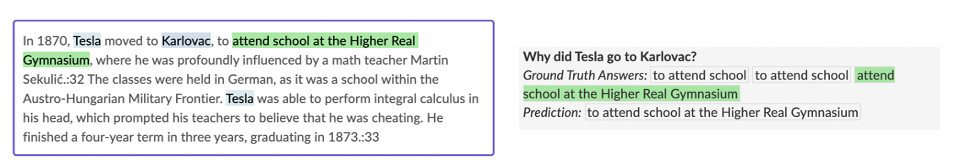
2. F1 Score: 
    - EM과 다르게 부분 점수를 제공합니다. 예를 들어, 정답은 "Barack Obama"지만 예측이 "Obama"일 때, EM의 경우 0점을 받겠지만 F1 Score는 겹치는 단어도 있는 것을 고려해 부분 점수를 줍니다.
    - 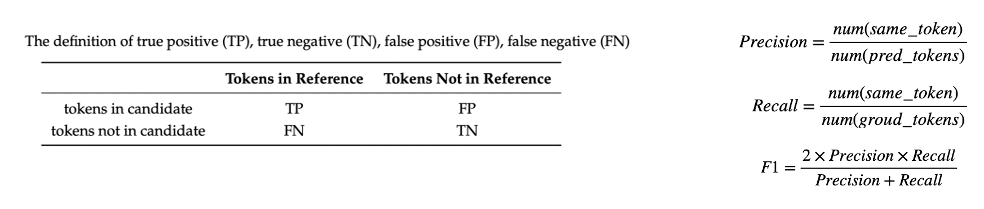

EM 기준으로 랭킹을 산정하고, F1은 참고용으로만 활용합니다.

## Import libraries

In [2]:
import os, sys
from pathlib import Path
from glob import glob

In [3]:
BASE_PATH = Path('.').resolve().parent
BASE_PATH

PosixPath('/opt/ml/jaepil')

In [4]:
sys.path.append(BASE_PATH.as_posix())

In [5]:
sys.path

['/opt/ml/jaepil/code',
 '/opt/conda/envs/dl38/lib/python38.zip',
 '/opt/conda/envs/dl38/lib/python3.8',
 '/opt/conda/envs/dl38/lib/python3.8/lib-dynload',
 '',
 '/opt/conda/envs/dl38/lib/python3.8/site-packages',
 '/opt/conda/envs/dl38/lib/python3.8/site-packages/locket-0.2.1-py3.8.egg',
 '/opt/conda/envs/dl38/lib/python3.8/site-packages/IPython/extensions',
 '/opt/ml/.ipython',
 '/opt/ml/jaepil']

In [6]:
import numpy as np
import pandas as pd

In [7]:
import pyarrow as pa

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# matplotlib 한국어 폰트
font_path = './fonts/NanumBarunGothic.ttf'
font = mpl.font_manager.FontProperties(fname=font_path, size=9)

plt.rc('font', family='NanumBarunGothic')

In [10]:
import json
import pickle

In [11]:
import tqdm
tqdm.__version__

'4.49.0'

In [12]:
from tqdm import tqdm
# from tqdm.notebook import tqdm

from time import time

In [13]:
from tqdm import tqdm, tqdm_pandas
tqdm.pandas()

In [14]:
import re

In [15]:
import torch

torch.cuda.is_available()

True

In [16]:
import datasets 

In [17]:
## custom libraries: requires konlpy, mecab

import trainer_qa
import utils_qa

## Load data

In [29]:
data_path = BASE_PATH / "input" / "data" / "data"
data_path

PosixPath('/opt/ml/jaepil/input/data/data')

In [30]:
train_path = data_path / "train_dataset"

train_data_path = train_path / "train"
val_data_path = train_path / "validation"

In [31]:
test_path = data_path / "test_dataset"

test_data_path = test_path / "validation"

In [32]:
with open(data_path / "wikipedia_documents.json", "r", encoding='utf-8') as j:
    wiki_docs_json = json.load(j)

In [33]:
wiki_docs_df = pd.DataFrame(wiki_docs_json.values())
wiki_docs_df.drop_duplicates(inplace=True)
wiki_docs_df

,text,corpus_source,url,domain,title,author,html,document_id
0,"이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...",위키피디아,TODO,None,나라 목록,None,None,0
1,이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...,위키피디아,TODO,None,나라 목록,None,None,1
2,현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...,위키피디아,TODO,None,백남준,None,None,2
3,"아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로...",위키피디아,TODO,None,아오조라 문고,None,None,3
4,저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,위키피디아,TODO,None,아오조라 문고,None,None,4
...,...,...,...,...,...,...,...,...
60608,"오키나와 현립 박물관·미술관( , Okinawa Prefectural Museum ...",위키피디아,None,None,오키나와 현립 박물관·미술관,None,None,60608
60609,"1936년 7월, 오키나와현 교육위원회 부설 향토 박물관(沖縄県教育会附設郷土博物館)...",위키피디아,None,None,오키나와 현립 박물관·미술관,None,None,60609
60610,박물관은 개관 10주년이되는 2017년에 관의 애칭 및 마스코트를 일반인에게 공모했...,위키피디아,None,None,오키나와 현립 박물관·미술관,None,None,60610
60611,단결권 및 단체교섭권 협약(Right to Organise and Collectiv...,위키피디아,None,None,단결권 및 단체교섭권 협약,None,None,60611


문단은 엔터 두 번으로 (\n\n) 나눠져 있는 것을 확인할 수 있다. 

이를 통해 문장 말고 문단으로 더 document를 나눌 수도 있다. 

In [34]:
wiki_docs_df.text[0]

'이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다.\n\n이 목록은 명료화를 위해 두 부분으로 나뉘어 있다.\n\n# 첫 번째 부분은 바티칸 시국과 팔레스타인을 포함하여 유엔 등 국제 기구에 가입되어 국제적인 승인을 널리 받았다고 여기는 195개 나라를 나열하고 있다.\n# 두 번째 부분은 일부 지역의 주권을 사실상 (데 팍토) 행사하고 있지만, 아직 국제적인 승인을 널리 받지 않았다고 여기는 11개 나라를 나열하고 있다.\n\n두 목록은 모두 가나다 순이다.\n\n일부 국가의 경우 국가로서의 자격에 논쟁의 여부가 있으며, 이 때문에 이러한 목록을 엮는 것은 매우 어렵고 논란이 생길 수 있는 과정이다. 이 목록을 구성하고 있는 국가를 선정하는 기준에 대한 정보는 "포함 기준" 단락을 통해 설명하였다. 나라에 대한 일반적인 정보는 "국가" 문서에서 설명하고 있다.'

In [35]:
train_dataset = datasets.load_from_disk(train_data_path)
train_dataset

Dataset({
    features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 3952
})

In [36]:
train_df = pd.DataFrame(train_dataset)
train_df.head()

,title,context,question,id,answers,document_id,__index_level_0__
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,"{'answer_start': [235], 'text': ['하원']}",18293,42
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,"{'answer_start': [212], 'text': ['《경영의 실제》']}",51638,2873
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,"{'answer_start': [510], 'text': ['백성']}",5028,230
3,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,mrc-0-001510,"{'answer_start': [625], 'text': ['중국']}",34146,992
4,계사명 사리구,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,mrc-0-000823,"{'answer_start': [30], 'text': ['4개']}",47334,548


In [37]:
train_df.context[0]

'미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\\n\\n미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.\\n\\n미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05'

In [38]:
val_dataset = datasets.load_from_disk(val_data_path)
val_dataset

Dataset({
    features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 240
})

In [39]:
val_df = pd.DataFrame(val_dataset)
val_df.head()

,title,context,question,id,answers,document_id,__index_level_0__
0,전효숙,"순천여자고등학교 졸업, 1973년 이화여자대학교를 졸업하고 1975년 제17회 사법...",처음으로 부실 경영인에 대한 보상 선고를 받은 회사는?,mrc-0-003264,"{'answer_start': [284], 'text': ['한보철강']}",9027,2146
1,스토우빌선,요크 카운티 동쪽에 처음으로 여객 열차 운행이 시작한 시점은 1868년 토론토 & ...,스카버러 남쪽과 코보콘그 마을의 철도 노선이 처음 연장된 연도는?,mrc-0-004762,"{'answer_start': [146], 'text': ['1871년']}",51765,3106
2,촐라,"촐라 정부\n 촐라의 정부 체제는 전제군주제였으며,2001 촐라의 군주는 절대적인 ...",촌락에서 운영 위원 후보자 이름을 쓰기위해 사용된 것은?,mrc-1-001810,"{'answer_start': [517], 'text': ['나뭇잎']}",15694,1180
3,백조 기사,프랑스의 십자군 무훈시는 1099년 예루살렘 왕국의 통치자가 된 고드프루아 드 부용...,로타이르가 백조를 구하기 위해 사용한 것은?,mrc-1-000219,"{'answer_start': [1109], 'text': ['금대야']}",59536,141
4,탈관료제화,탈관료제화는 현대사회에서 관료제 성격이 약화되는 현상이다. 현대사회에서 관료제는 약...,의견을 자유롭게 나누는 것은 조직 내 어떤 관계에서 가능한가?,mrc-1-000285,"{'answer_start': [386], 'text': ['수평적 관계']}",32991,184


In [40]:
test_dataset = datasets.load_from_disk(test_data_path)
test_dataset

Dataset({
    features: ['id', 'question'],
    num_rows: 600
})

In [41]:
test_df = pd.DataFrame(test_dataset)
test_df.head()

,question,id
0,유령'은 어느 행성에서 지구로 왔는가?,mrc-1-000653
1,용병회사의 경기가 좋아진 것은 무엇이 끝난 이후부터인가?,mrc-1-001113
2,돌푸스에게 불특정 기간동안 하원이 잠시 쉬는 것을 건의 받았던 인물은?,mrc-0-002191
3,"마오리언어와 영어, 뉴질랜드 수화를 공식 언어로 사용하는 나라는?",mrc-0-003951
4,디엔비엔푸 전투에서 보응우옌잡이 상대한 국가는?,mrc-1-001272


## Data stats

### `answers`의 특성은 어떻게 되는가? 

In [42]:
train_answers_df = pd.DataFrame(list(train_df.answers))
train_answers_df

,answer_start,text
0,[235],[하원]
1,[212],[《경영의 실제》]
2,[510],[백성]
3,[625],[중국]
4,[30],[4개]
...,...,...
3947,[317],[지질 구조]
3948,[616],[뉴저지]
3949,[255],[칼 에케르트]
3950,[476],[슬라브 신화]


#### 한자나 특문 등 포함된 정답은?

In [53]:
train_text = train_answers_df.text
train_text = [text[0] for text in train_text]

not_kor_eng_re = re.compile("[^ㄱ-힣|a-zA-z|\d]")
hanja_re = re.compile(r'[\u4e00-\u9fff]+')

# [re.search(not_kor_eng_re, text) for text in train_text]
# [re.search(hanja_re, text) for text in train_text]

In [43]:
val_answers_df = pd.DataFrame(list(val_df.answers))
val_answers_df

,answer_start,text
0,[284],[한보철강]
1,[146],[1871년]
2,[517],[나뭇잎]
3,[1109],[금대야]
4,[386],[수평적 관계]
...,...,...
235,[1084],[제 양왕]
236,[343],['일곱 개의 신전 광장']
237,[247],[미나미 지로]
238,[563],"[200,000명]"


`answer_start` list에 2개 이상의 원소가 들어있거나 원소가 없는 경우도 존재하는가? 

In [33]:
[l for l in train_answers_df.answer_start if len(l) != 1] # 없다. answer_start는 항상 길이가 1이다. 

[]

`text`는 space 기준으로 나눴을 때 최대 몇 n그램을 가지는가? 

각 `text`에 들어있는 space의 갯수를 `Counter`로 확인해보자. 

In [34]:
from collections import Counter

In [35]:
text_temp = [Counter(t[0]) for t in train_answers_df.text]
text_temp = [c[' '] for c in text_temp]
Counter(text_temp)

Counter({0: 2288,
         1: 1065,
         2: 349,
         4: 52,
         7: 7,
         5: 39,
         3: 120,
         6: 18,
         14: 1,
         8: 4,
         12: 1,
         19: 1,
         9: 3,
         13: 2,
         17: 1,
         15: 1})

<AxesSubplot:ylabel='count'>

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


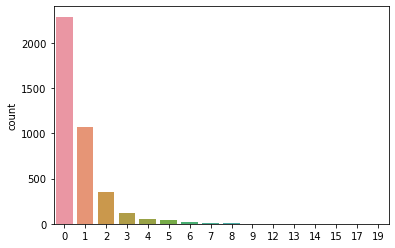

In [36]:
sns.countplot(x=text_temp)

In [37]:
text_temp.index(19)

996

In [38]:
train_answers_df.text[996]

['“나는 국경일에 일장기를 게양하는 것을 반대하지 않는다. 왜냐하면 우리가 일본의 통치하에 있는 한 우리는 그 통치의 명령에 복종해야 하기 때문이다.”']

In [39]:
train_df.iloc[996]

title                                                              윤치호
context              3·1 운동\n1919년 3월 3·1 운동 당시, 독립운동가들로부터 국민대표로 서명...
question                          윤치호가 일부 독립운동 지도자들로부터 비난 받았던 일기의 내용은?
id                                                        mrc-0-002792
answers              {'answer_start': [1122], 'text': ['“나는 국경일에 일장...
document_id                                                       5307
__index_level_0__                                                 1833
Name: 996, dtype: object

`id`의 중간 숫자는 어떤 의미가 있는가?

특별히 의미는 없는 것 같다. 뭔가 있다해도 이걸 쓰는건 cheating인듯..  

In [40]:
ids_l = list(train_df.id)

ids_0_l = [x for x in ids_l if x.split('-')[1] == '0']
ids_1_l = [x for x in ids_l if x.split('-')[1] == '1']

ids_etc_l = [x for x in ids_l if x.split('-')[1] != '1' and x.split('-')[1] != '0'] # [] 

In [41]:
id_0_df = train_df[train_df.id.isin(ids_0_l)]
id_0_df

,title,context,question,id,answers,document_id,__index_level_0__
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,"{'answer_start': [212], 'text': ['《경영의 실제》']}",51638,2873
3,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,mrc-0-001510,"{'answer_start': [625], 'text': ['중국']}",34146,992
4,계사명 사리구,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,mrc-0-000823,"{'answer_start': [30], 'text': ['4개']}",47334,548
5,용아병,델포이의 신탁에 따라 암소를 따라간 카드모스는 테베 땅에 이르렀다. 카드모스는 암소...,카드모스의 부하들이 간 곳에는 무엇이 있었는가?,mrc-0-005265,"{'answer_start': [91], 'text': ['드래곤']}",37482,3429
6,호반,"제27회와 제73회에 출현한다. 관우는 자신을 저지하는 공수, 맹탄, 한복, 변희를...",관우를 불태워 죽이려한 사람 누구인가?,mrc-0-000532,"{'answer_start': [68], 'text': ['형양태수 왕식']}",24395,360
...,...,...,...,...,...,...,...
3946,막리지의 난,"628년에 당이 마지막 남은 군벌 세력과 서돌궐을 제거하고 통일하였듯, 당의 성장을...",영류왕이 천리장성의 건축 총괄 책임을 맡겼던 인물은 누구인가?,mrc-0-004590,"{'answer_start': [474], 'text': ['연태조(淵太祚)']}",59702,2996
3947,이오 (위성),이오의 산\n이오의 산 목록\n 이오에는 100~150개의 산이 있다. 이들 산의 ...,대부분의 이오의 산이 형성되는데 영향을 끼친 것은?,mrc-0-005285,"{'answer_start': [317], 'text': ['지질 구조']}",8275,3445
3949,빈 필하모니 관현악단,1842년에 작곡가이자 지휘자인 오토 니콜라이가 빈 궁정 오페라극장 소속 관현악단을...,1854년에 니콜라이의 뒤를 이어 상임 지휘자로서 활동한 인물은?,mrc-0-003429,"{'answer_start': [255], 'text': ['칼 에케르트']}",12730,2252
3950,드래곤,원어는 고대 그리스어까지 거슬러 올라간다. 영어 문헌에 이 말이 나타나기 시작한 것...,드래곤의 암수 구분이 있는 신화는?,mrc-0-003956,"{'answer_start': [476], 'text': ['슬라브 신화']}",10924,2595


In [42]:
id_1_df = train_df[train_df.id.isin(ids_1_l)]
id_1_df

,title,context,question,id,answers,document_id,__index_level_0__
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,"{'answer_start': [235], 'text': ['하원']}",18293,42
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,"{'answer_start': [510], 'text': ['백성']}",5028,230
10,황해 해전 (1894년),"이후, 여순항에 피항한 북양함대는 일본 육군에 의해 육지로부터 포위될 뻔 했다. 북...",정여창은 어떻게 죽었나?,mrc-1-000128,"{'answer_start': [817], 'text': ['음독자살']}",26376,80
14,레위기,너는 이스라엘 백성 온 회중에게 이렇게 일러주어라. '나 야훼 너희 하느님이 거룩하...,유대교의 지나친 차별을 타파하려한 사람은?,mrc-1-001008,"{'answer_start': [497], 'text': ['예수']}",5251,652
15,권번,권번은 주식회사 제도로 운영되었으며 일제가 그 관리를 주도하였다. 일제가 권번을 관...,권번에서 요릿집에 제공한 기생 명부의 이름은?,mrc-1-000732,"{'answer_start': [524], 'text': [''초일기'']}",47810,471
...,...,...,...,...,...,...,...
3926,교황 니콜라오 2세,니콜라오 2세는 자신의 지위를 확고히 하기 위해 즉시 노르만족과 우호적인 관계를 맺...,니콜라오 2세가 장엄한 예식을 주재함으로써 우호관계를 형성한 세력은?,mrc-1-000678,"{'answer_start': [355], 'text': ['노르만족']}",6743,436
3931,포베글리아,포베글리1년 파두아(*북부 이탈리아 도시)로부터 전염병을 피해 이주한 곳으로 처음 ...,1379년에 이탈리아의 주요 거점지로 인정받았던 장소는?,mrc-1-001779,"{'answer_start': [93], 'text': ['베니스']}",25523,1163
3935,델라웨어주,"델라웨어 주는 노예제 찬성 주였으며, 합중국의 초기 13개의 주들 중 하나이기도 하...",링컨이 노예 해방 선언을 공표한 해는?,mrc-1-000169,"{'answer_start': [215], 'text': ['1863년']}",5973,109
3945,미국 알래스카 육군,"1940년, 제2차 세계 대전에 대비하기 위해 알래스카 방위군이 창설되었다. 랜드리...",알래스카 고속도로가 미국 본토에 수행하는 역할은?,mrc-1-000818,"{'answer_start': [295], 'text': ['병력과 물류를 보급할 ...",35815,529


## Export df pkl files 

In [43]:
export_path = BASE_PATH / "output" / "processed_data"
export_path

PosixPath('/opt/ml/jaepil/output/processed_data')

In [44]:
# wiki_docs_df.to_pickle(export_path / 'wiki_docs_df.pkl')
# train_df.to_pickle(export_path / 'train_df.pkl')
# val_df.to_pickle(export_path / 'val_df.pkl')

## Explore stats

### simple length

In [45]:
train_context_length = train_df.context.apply(len)
train_question_length = train_df.question.apply(len)
wiki_text_length = wiki_docs_df.text.apply(len)

<AxesSubplot:>

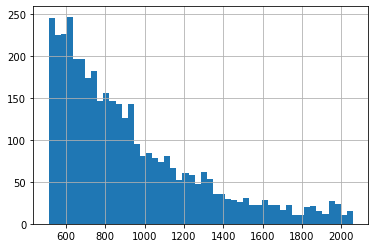

In [46]:
train_context_length.hist(bins=50)

<AxesSubplot:>

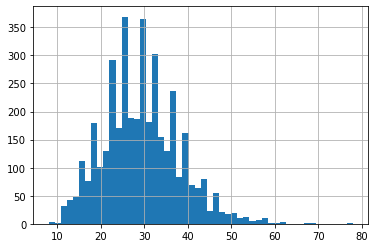

In [47]:
train_question_length.hist(bins=50)

<AxesSubplot:>

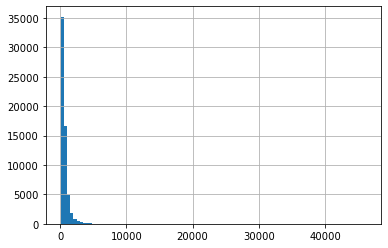

In [48]:
wiki_text_length.hist(bins=100)

### tokenized length

In [49]:
from pororo import Pororo

In [50]:
np.random.seed(123)
random_idx = np.random.choice(100, 20)
random_idx

array([66, 92, 98, 17, 83, 57, 86, 97, 96, 47, 73, 32, 46, 96, 25, 83, 78,
       36, 96, 80])

In [51]:
example_df = train_df.iloc[random_idx]
example_df.head()

,title,context,question,id,answers,document_id,__index_level_0__
66,기세이 본선,나고야 방면으로 직결 운행하는 열차로는 쾌속 《미에》 호가 쓰 역과 다키 역 사이를...,쾌속 《미에》 호는 어느 방향으로 직결 운행하는 열차인가요?,mrc-0-001337,"{'answer_start': [0], 'text': ['나고야']}",30248,878
92,덴노즈아이루,덴노즈아이루(天王洲アイル)는 일본 도쿄도 시나가와구 히가시시나가와 임해부에 있는 재...,도카이도 신칸센이 지나가며 시나가와 역까지 가는 교통수단은?,mrc-0-003354,"{'answer_start': [230], 'text': ['도에이 버스']}",44283,2205
98,텀블벅,텀블벅(tumblbug)의 특징은 역시 다양한 분야에 다양한 시도들을 적극 권장하며...,정해진 기간동안 목표 금액에 도달하지 못할 경우 돈을 받지 못하는 사람은?,mrc-0-003303,"{'answer_start': [380], 'text': ['창작자']}",33445,2172
17,팀 웨이크필드,2009년 웨이크필드는 레드삭스와 함께 자신의 15번째 시즌에 들어갔다. 4월 15...,웨이크필드가 15번째 시즌에 활약한 팀의 이름은?,mrc-0-000424,"{'answer_start': [13], 'text': ['레드삭스']}",52733,285
83,오토망게어족,오토망게어족(Oto-Manguean languages)은 여러 아메리카 원주민 언어...,오토망게어족을 가장 많이 사용하는 곳은 어디인가?,mrc-1-001688,"{'answer_start': [214], 'text': ['오아하카주']}",55072,1109


In [52]:
Pororo.available_models('tokenize')

'Available models for tokenize are ([lang]: en, [model]: moses, bpe32k.en, roberta, sent_en), ([lang]: ko, [model]: bpe4k.ko, bpe8k.ko, bpe16k.ko, bpe32k.ko, bpe64k.ko, unigram4k.ko, unigram8k.ko, unigram16k.ko, unigram32k.ko, unigram64k.ko, jpe4k.ko, jpe8k.ko, jpe16k.ko, jpe32k.ko, jpe64k.ko, mecab.bpe4k.ko, mecab.bpe8k.ko, mecab.bpe16k.ko, mecab.bpe32k.ko, mecab.bpe64k.ko, char, jamo, word, mecab_ko, sent_ko), ([lang]: ja, [model]: mecab, bpe8k.ja, sent_ja), ([lang]: zh, [model]: jieba, sent_zh)'

안됨:
- `jpe32k.ko`: `<unk>` 가 없다 함. 
- `mecab_ko`: 따로 설치해야 하는듯 


#### `model='bpe32k.ko'`

In [53]:
tk = Pororo(task='tokenization', lang='ko', model='bpe32k.ko')
tk

[TASK]: TOKENIZATION
[LANG]: KO
[MODEL]: bpe32k.ko

In [54]:
%%time

example_tk_question = train_df.question.apply(tk)
example_tk_question

CPU times: user 304 ms, sys: 12 ms, total: 316 ms
Wall time: 314 ms


0       [▁대통령을, ▁포함한, ▁미국의, ▁행정부, ▁견제, 권을, ▁갖는, ▁국가, ▁...
1         [▁현대, 적, ▁인사, 조직, 관, 리의, ▁시, 발, 점이, ▁된, ▁책은, ?]
2       [▁강희, 제가, ▁17, 17, 년에, ▁쓴, ▁글은, ▁누구를, ▁위해, ▁쓰여...
3       [▁11, ~12, 세기에, ▁제작된, ▁본, 존, 불, 은, ▁보통, ▁어떤, ▁...
4       [▁명, 문이, ▁적힌, ▁유, 물을, ▁구성하는, ▁그릇, 의, ▁총, ▁개, 수...
                              ...                        
3947    [▁대부분의, ▁이, 오의, ▁산이, ▁형성, 되는데, ▁영향을, ▁끼친, ▁것은, ?]
3948                          [▁애니, 는, ▁어디서, ▁태어났, 는가, ?]
3949    [▁18, 54, 년에, ▁니콜라이, 의, ▁뒤를, ▁이어, ▁상임, ▁지휘, 자로...
3950               [▁드래곤, 의, ▁암, 수, ▁구분이, ▁있는, ▁신, 화는, ?]
3951    [▁올, 레, ▁폰, ▁보이, 스트, ▁이후에, ▁시장으로, ▁임명된, ▁사람은, ...
Name: question, Length: 3952, dtype: object

In [55]:
example_tk_question[0]

['▁대통령을', '▁포함한', '▁미국의', '▁행정부', '▁견제', '권을', '▁갖는', '▁국가', '▁기관은', '?']

#### `model='mecab.bpe32k.ko'`

In [56]:
tk = Pororo(task='tokenization', lang='ko', model='mecab.bpe32k.ko')
tk

[TASK]: TOKENIZATION
[LANG]: KO
[MODEL]: mecab.bpe32k.ko

In [57]:
%%time

example_tk_question = example_df.question.apply(tk)
example_tk_question

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.74 ms


66    [▁쾌속, ▁, 《, 미, 에, 》, ▁호, 는, ▁어느, ▁방향, 으로, ▁직결,...
92    [▁도카이도, ▁신칸센, 이, ▁지나가, 며, ▁시나가와, ▁역, 까, 지, ▁가,...
98    [▁정해진, ▁기간, 동안, ▁목표, ▁금액, 에, ▁도달, 하, 지, ▁못할, ▁...
17    [▁웨이크, 필드, 가, ▁15, 번, 째, ▁시즌, 에, ▁활약, 한, ▁팀, 의...
83    [▁오토, 망, 게, 어, 족, 을, ▁가장, ▁많이, ▁사용, 하, 는, ▁곳, ...
57         [▁작중, ▁샤를, ▁지, ▁브리타니아, 가, ▁비판, 한, ▁사상, 은, ?]
86                               [▁우메, 노, 의, ▁사인, 은, ?]
97    [▁김대중, 을, ▁구하, 기, ▁위해, ▁캐, 스퍼, ▁와인, 버거, ▁미, ▁국...
96     [▁소나타, 의, ▁시초, 가, ▁된, ▁연습, 곡, 을, ▁만든, ▁사람, 은, ?]
47    [▁풍수지리, 사상, 의, ▁관점, 에, 서, ▁보, 면, ▁선, 몽, 대, 는, ...
73    [▁경찰관, 이, ▁딱지, 를, ▁떼, 지, ▁않, 은, ▁것, 은, ▁무엇, 을,...
32    [▁러시아, 가, ▁IS, IL, 과, ▁타, ▁반정부, ▁단체, 와, ▁전투, 를...
46    [▁초고층, ▁주거, 에, 서, ▁차량, 과, ▁사람, 의, ▁활동, ▁범위, ▁중...
96     [▁소나타, 의, ▁시초, 가, ▁된, ▁연습, 곡, 을, ▁만든, ▁사람, 은, ?]
25    [▁툴, 민, 은, ▁, ≪, 코스, 모, 폴리스, ≫, 에, 서, ▁근대, 과학,...
83    [▁오토, 망, 게, 어, 족, 을, ▁가장, ▁많이, ▁사용, 하, 는, ▁곳, ...
78    [▁핀, ▁막, ▁쿠, 월, 이, ▁복수, 하, 고, 자, ▁하, 는, ▁아버지, ...
36    [▁차, 바, 하르, 항, 은, ▁어떤, ▁나라, ▁덕분, 에, ▁미국, 의

In [58]:
example_tk_question.iloc[0]

['▁쾌속',
 '▁',
 '《',
 '미',
 '에',
 '》',
 '▁호',
 '는',
 '▁어느',
 '▁방향',
 '으로',
 '▁직결',
 '▁운행',
 '하',
 '는',
 '▁열차',
 '인',
 '가요',
 '?']

조사 단위까지 잘 자르는 `mecab.bpe32k.`를 기준으로 eda해보겠음. 

In [59]:
%%time

train_tk_question = train_df.question.apply(tk)
train_tk_context = train_df.context.apply(tk)

CPU times: user 6.17 s, sys: 104 ms, total: 6.28 s
Wall time: 6.27 s


In [60]:
print(train_tk_context[0])

['▁미국', '▁상', '의원', '▁또는', '▁미국', '▁상원', '(', 'U', 'n', 'ited', '▁States', '▁S', 'en', 'ate', ')', '은', '▁양원제', '인', '▁미국', '▁의회', '의', '▁상원', '이', '다', '.', '\\', 'n', '\\', 'n', '미', '국', '▁부통령', '이', '▁상원', '의장', '이', '▁된다', '.', '▁각', '▁주', '당', '▁2', '명', '의', '▁상원', '의원', '이', '▁선출', '되', '어', '▁100', '명', '의', '▁상원', '의원', '으로', '▁구성', '되', '어', '▁있', '다', '.', '▁임기', '는', '▁6', '년', '이', '며', ',', '▁2', '년', '마', '다', '▁50', '개', '주', '▁중', '▁1', '/', '3', '씩', '▁상원', '의원', '을', '▁새로', '▁선출', '하여', '▁연방', '에', '▁보낸다', '.', '\\', 'n', '\\', 'n', '미', '국', '▁상원', '은', '▁미국', '▁하원', '과', '는', '▁다르', '게', '▁미국', '▁대통령', '을', '▁수반', '으로', '▁하', '는', '▁미국', '▁연방', '▁행정부', '에', '▁각종', '▁동의', '를', '▁하', '는', '▁기관', '이', '다', '.', '▁하원', '이', '▁세금', '과', '▁경제', '에', '▁대한', '▁권한', ',', '▁대통령', '을', '▁포함', '한', '▁대다수', '의', '▁공무원', '을', '▁파면', '할', '▁권한', '을', '▁갖', '고', '▁있', '는', '▁국민', '을', '▁대표', '하', '는', '▁기관', '인', '▁반면', '▁상원', '은', '▁미국', '의', '▁주', '를', '▁대표', '한다', '.', '▁즉', '

영어는 엄청 이상하게 잘렸다. 

In [61]:
train_tk_question_len = train_tk_question.apply(len)
train_tk_context_len = train_tk_context.apply(len)

<AxesSubplot:>

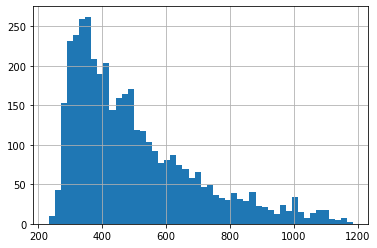

In [62]:
train_tk_context_len.hist(bins=50)

<AxesSubplot:>

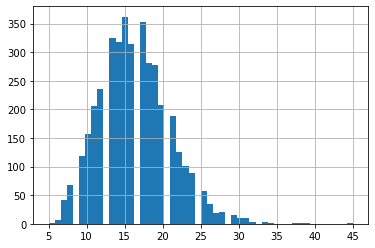

In [63]:
train_tk_question_len.hist(bins=50)

## Zero-shot Topic Classification using Pororo

위키백과 최상위 주제분류를 이용해보자. 

https://ko.wikipedia.org/wiki/%EB%B6%84%EB%A5%98:%EC%A3%BC%EC%A0%9C_%EB%B6%84%EB%A5%98

In [64]:
zsl = Pororo('zero-topic', lang='ko')
zsl

[TASK]: ZERO-TOPIC
[LANG]: KO
[MODEL]: brainbert.base.ko.kornli

In [65]:
zsl('''라리가 사무국, 메시 아닌 바르사 지지..."바이 아웃 유효" [공식발표]''', ["스포츠", "사회", "정치", "경제", "생활/문화", "IT/과학"])

{'스포츠': 94.15,
 '사회': 37.11,
 '정치': 74.26,
 '경제': 39.18,
 '생활/문화': 71.15,
 'IT/과학': 34.71}

In [66]:
wiki_categories = [
    "건강",
    "게임",
    "경제",
    "과학기술",
    "군사",
    "대중 매체",
    "문화",
    "물질",
    "법",
    "사람",
    "사회",
    "산업",
    "생명",
    "생물",
    "수학",
    "역사",
    "예술",
    "인간 본성",
    "인문학",
    "자연",
    "정치",
    "종교",
    "지리",
#     "참고 문헌", # 이건 제외하겠다. 
    "철학",
    "학문",
]

In [67]:
example = train_df.context[100]
example

'그의 죽음으로 좌우합작위원회는 구심점을 잃게 된다. 제2차 미소공위는 추진하던 중 이후 중재자가 없어지자 극좌,극우 양극단 세력의 갈등이 표출하였고, 끝내 미국-소련의 입장만 확인한 채 1947년 10월에 제2차 미소공위는 완전히 결렬되어 미국이 한반도 문제를 UN으로 이관함으로써 좌우합작위원회는 1947년 12월에 공식 해체된다. 결국, \'통일임시정부\' 수립을 위한 좌우합작운동은 좌절되어 실패로 끝났고 한반도는 \'남한 내 단독정부 수립\'안이 확정되기에 이르렀다.\\n\\n1947년 7월 19일 여운형이 피습,절명하여 암살되었을 당시 갑작스런 그의 죽음은 많은 사람들에게 커다란 충격을 주었다. 1947년 8월 3일 광화문 인민당사 앞에서 발인식이 거행되었다. 그의 영결식은 인민장으로 치러졌다. \\n\\n영결식에 약 60여만명의 수많은 추모인파가 몰렸다고 한다. 이는 광복 이후 최다 인파가 모인 것인데, 민중들이 슬픔에 동참하기 위해 자발적으로 흰 옷을 입어서 서울시내가 하얗게 뒤덮였다고 한다. 영구는 결식장인 서울운동장(동대문운동장)으로 향해 서서히 갔고, 장례 행렬은 11시 40분에 서울운동장에 도착하여 영결식이 치러졌다. 서울 운동장에서 베를린 올림픽 마라톤 금메달리스트 손기정과 역도선수 김성집 등 체육인들이 그의 관을 운구하였다. \\n\\n그의 시신은 포르말린으로 방부처리되어 쇠로 만들어진 관에 안치되었다. 통일이 되는 날에 다시 장사를 지내기 위함이었다. 그가 죽자 미 군정장관 하지가 육각수은관을 미국에서 특별 주문해 가져왔다고 한다.\\n\\n 여운형의 묘소는 서울시 강북구 우이동에 안치되었으며 강북구 수유동에서 멀지 않은 솔밭공원 근처에 있다. 한 때 1961년 5.16 군사정변 직후 우이동 묘소 땅이 채윤혁 개인에게 불하받게 되어 여운형 시신이 오갈 데 없는 딱한 처지에 놓인 적이 있었다. 당시 국회의원이던 여운형의 동생 여운홍이 법적으로 어떻게 해볼 길이 없으니 대통령 박정희한테 직접 문제를 해결해달라고 부탁했다. 이에 대해 박정희는

토큰은 길이 512를 넘길 수 없다. (`len` 기준이 아니고 토큰임.)

In [68]:
example_paragraphs = example.split("\\n\\n")
len(example_paragraphs)

7

In [69]:
paragraphs_zsl_l = []

for paragraph in example_paragraphs:
    paragraphs_zsl_l.append(zsl(paragraph, wiki_categories))

In [70]:
paragraph_max_cat = [max(paragraph, key=paragraph.get) for paragraph in paragraphs_zsl_l]
paragraph_max_cat

['사람', '사람', '사람', '사람', '군사', '사람', '사람']

In [71]:
from collections import Counter

counter = Counter(paragraph_max_cat)
counter

Counter({'사람': 6, '군사': 1})

In [72]:
counter.most_common(1)

[('사람', 6)]

In [73]:
pp = "hehehe lololo"

pp.split("\\n\\n")

['hehehe lololo']

In [74]:
def get_most_common_cat_from_context(context, cat_l=wiki_categories):
    paragraphs_l = context.split("\\n\\n")
    paragraphs_l = [paragraph for paragraph in paragraphs_l if len(tk(paragraph)) < 512]
    
    if paragraphs_l == []:
        return "null"
    
    paragraphs_zsl_l = [zsl(paragraph, cat_l) for paragraph in paragraphs_l]
    max_cat_l = [max(paragraph, key=paragraph.get) for paragraph in paragraphs_zsl_l]
    counter = Counter(max_cat_l)
    most_common = counter.most_common(1)[0][0]
    
    return most_common

아래 작업들은 매우 오래걸린다. 

In [75]:
%%time

# train_df["context_zsl_cat"] = train_df.context.progress_apply(get_most_common_cat_from_context)

  1%|          | 45/3952 [01:03<1:32:23,  1.42s/it]


KeyboardInterrupt: 

아래에서 answer paragraph 생성하는 코드부터 돌려줘야 함. 

In [76]:
%%time

# You have to run the code that creates answer_paragraph first 
# train_df["answer_paragraph_zsl_cat"] = train_df.answer_paragraph.progress_apply(get_most_common_cat_from_context)

AttributeError: 'DataFrame' object has no attribute 'answer_paragraph'

In [77]:
%%time

# train_df["question_zsl_cat"] = train_df.question.progress_apply(get_most_common_cat_from_context)

  0%|          | 1/3952 [00:00<01:09, 56.64it/s]


KeyboardInterrupt: 

In [92]:
output_path = BASE_PATH / "output" 
output_processed_path = output_path / "processed_data"

train_df = pd.read_pickle(output_processed_path / "train_df.pkl")

In [93]:
train_df.head()

,title,context,question,id,answers,document_id,__index_level_0__
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,"{'answer_start': [235], 'text': ['하원']}",18293,42
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,"{'answer_start': [212], 'text': ['《경영의 실제》']}",51638,2873
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,"{'answer_start': [510], 'text': ['백성']}",5028,230
3,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,mrc-0-001510,"{'answer_start': [625], 'text': ['중국']}",34146,992
4,계사명 사리구,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,mrc-0-000823,"{'answer_start': [30], 'text': ['4개']}",47334,548


## MRC using Pororo

In [79]:
mrc = Pororo('mrc', lang='ko')
mrc # python-mecab-ko 안깔려있다고 에러남. 근데 pip list 해보면 깔려있음. (mecab-python3)

[TASK]: MRC
[LANG]: KO
[MODEL]: brainbert.base.ko.korquad

In [80]:
%%time

answers_l = []
for question, context in tqdm(list(zip(train_df.question, train_df.context))):
    answers_l.append(mrc(question, context))

 21%|██        | 818/3952 [00:13<00:51, 60.31it/s]


KeyboardInterrupt: 

In [81]:
import evaluation

In [82]:
gt = train_df.answers[0]
gt

{'answer_start': [235], 'text': ['하원']}

In [83]:
pred = answers_l[0]
pred

('하원', (189, 191))

In [84]:
evaluation.f1_score(pred[0], gt['text'][0])

1.0

In [85]:
evaluation.exact_match_score(pred[0], gt['text'][0])

True

In [86]:
f1_l = []
em_l = []

for pred, gt in tqdm(zip(answers_l, train_df.answers)):
    pred = pred[0]
    gt = gt['text'][0]
    
    f1_l.append(evaluation.f1_score(pred, gt))
    em_l.append(evaluation.exact_match_score(pred, gt))
    

818it [00:00, 12431.85it/s]


In [87]:
sum(f1_l) / len(f1_l)

0.725667478870529

In [88]:
sum(em_l) / len(em_l)

0.5513447432762836

## Sentence Embedding using Pororo

### Embed train question & context 

In [94]:
se = Pororo(task="sentence_embedding", lang="ko")
se

[TASK]: SENTENCE_EMBEDDING
[LANG]: KO
[MODEL]: brainsbert.base.ko.kornli.korsts

In [95]:
%%time

example_se_question = train_df.question.progress_apply(se)
example_se_question

100%|██████████| 3952/3952 [00:58<00:00, 67.25it/s]

CPU times: user 58.7 s, sys: 216 ms, total: 58.9 s
Wall time: 58.8 s


0       [0.06523498, 0.040979724, 0.32197776, 0.183066...
1       [-0.07001264, 0.08859611, 0.42348206, 0.185355...
2       [-0.055644535, -0.07688755, 0.19998513, 0.0727...
3       [-0.0868163, -0.22128436, -0.42974135, 0.12483...
4       [-0.49783763, -0.18613501, -0.14113903, -0.059...
                              ...                        
3947    [-0.027495619, -0.054911986, 0.3562842, 0.1060...
3948    [0.10290469, 0.021759262, 0.26842323, 0.128242...
3949    [-0.018194797, -0.3436707, -0.57160795, 0.0732...
3950    [-0.13560142, -0.26641193, -0.13407008, 0.1227...
3951    [-0.019975893, 0.006622081, -0.22405821, 0.021...
Name: question, Length: 3952, dtype: object

In [96]:
example_se_question[0].shape

(768,)

In [97]:
example_se_q_2d = np.stack(example_se_question.values)
example_se_q_2d

array([[ 0.06523498,  0.04097972,  0.32197776, ...,  0.06880494,
         0.10080572,  0.03246884],
       [-0.07001264,  0.08859611,  0.42348206, ...,  0.04272468,
        -0.20678635, -0.2152506 ],
       [-0.05564453, -0.07688755,  0.19998513, ...,  0.08710235,
         0.05537637,  0.14221318],
       ...,
       [-0.0181948 , -0.3436707 , -0.57160795, ...,  0.30394095,
         0.06984058,  0.05146996],
       [-0.13560142, -0.26641193, -0.13407008, ...,  0.03272256,
         0.13204475, -0.03901066],
       [-0.01997589,  0.00662208, -0.22405821, ...,  0.01514604,
        -0.05582194, -0.02369236]], dtype=float32)

In [98]:
example_se_q_2d.shape

(3952, 768)

In [99]:
%%time

train_se_question = train_df.question.progress_apply(se)
train_se_context = train_df.context.progress_apply(se)

100%|██████████| 3952/3952 [01:09<00:00, 57.20it/s]

CPU times: user 2min 7s, sys: 520 ms, total: 2min 8s
Wall time: 2min 8s


### Get pairwise distance for exhaustive retrieval

- cosine distance 
    - **Cosine distance is defined as 1.0 minus the cosine similarity.**
- L2 distance

In [100]:
from sklearn.metrics import pairwise_distances

In [101]:
query = train_se_question[0]
query = query[None, :]
query.shape

(1, 768)

In [102]:
context = train_se_context[0]
context = context[None, :]
context.shape

(1, 768)

In [103]:
pairwise_distances(query, context, metric='cosine')

array([[0.57824683]], dtype=float32)

In [104]:
pairwise_distances(query, context, metric='euclidean')

array([[6.0706635]], dtype=float32)

matrix 로 연산해 한꺼번에 distance를 계산하자

In [105]:
query_2d = np.stack(train_se_question.values)
query_2d.shape

(3952, 768)

In [106]:
context_2d = np.stack(train_se_context.values)
context_2d.shape

(3952, 768)

In [107]:
cosine_sim = pairwise_distances(query_2d, context_2d, metric='cosine')
cosine_sim.shape

(3952, 3952)

In [108]:
l2_norm = pairwise_distances(query_2d, context_2d, metric='euclidean')
l2_norm.shape

(3952, 3952)

In [109]:
dot = np.matmul(query_2d, context_2d.T)
dot.shape

(3952, 3952)

In [110]:
a = np.array([
    [1, 9, 3],
    [9, 1, 2],
    [3, 2, 1]
])

np.argmax(a, axis=1)

array([1, 0, 0])

In [111]:
# get the closest retrieval

cosine_retrieval_v = np.argmin(cosine_sim, axis=1)
l2_retrieival_v = np.argmin(l2_norm, axis=1)
dot_v = np.argmax(dot, axis=1)

In [112]:
train_df.question.iloc[0]

'대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?'

In [113]:
train_df.context.iloc[0] # gt

'미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\\n\\n미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.\\n\\n미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05'

In [114]:
idx = cosine_retrieval_v[0]
print(idx)
train_df.context.iloc[idx] # pred

60


"미국의 외교정책의 수립과 이행에 대한 주된 책임을 대통령이 지게 되어 있으나, 의회도 이에 대해 강한 통제력을 발휘할 수 있다. 우선 의회는 전쟁을 선포할 수 있는 권한이 있다. 하원은 대통령의 외교정책 수행에 필요한 예산에 대해 강한 통제력을 가지고 있으며, 상원도 재원에 대한 통제가 가능하다. 특히 상원의 경우에는 고급 외무 관리의 임명에 대한 통제력을 가지고 있을 뿐만 아니라, 미국이 체결하는 모든 조약에 대한 비준권을 가지고 있다. 의회의 이와 같은 제재 권한은 행정부와 의회의 갈등을 초래하는 요소로 작용한다. 에드워드 코르윈(Edward Samuel Corwin) 교수는 미국의 정치체계가 외교정책에 있어서 행정부와 의회 간의 투쟁을 초래한다고 지적한 바 있다. 그 좋은 예로서는 상원이 국제연맹 헌장의 비준을 거부한 사실을 들 수 있다. 의회와 행정부간에는 긴밀한 협조가 이루어지고 있다. 유엔헌장 비준 당시의 의회와 행정부 간의 긴밀한 협조는 너무나 유명하다. 그러나 이러한 협동외교는 한국에서 흔히 사용되고 있는 '초당외교'라는 말과는 엄격히 구분되어야 한다. 베트남 전쟁으로 말미암아 파생된 행정부와 의회 간의 갈등은 심각한 형편이었다. 그러나 의회가 대통령에 가하는 압력은 행정부의 독주를 견제하는 동시에 건전한 방향의 미국 대외정책을 모색하고 있다. 의회는 국민의 대표기구로서 국민의 의사와 직결돼 있다. 따라서 대외정책의 수립이나 이행 과정에도 항상 의회를 '문제아'로 취급하거나, 또는 그러한 범주 내에 의회의 기능을 이해해서는 안 된다."

### Evaluate metrics

Accuracy

In [115]:
# cosine similarity가 train data에서 제대로 retrieval한 비율
(cosine_retrieval_v == np.arange(len(cosine_retrieval_v))).sum() / len(cosine_retrieval_v)

0.1576417004048583

In [116]:
# l2 distance가 train data에서 제대로 retrieval한 비율
(l2_retrieival_v == np.arange(len(l2_retrieival_v))).sum() / len(l2_retrieival_v)

0.159665991902834

In [117]:
# cosine similarity와 l2 distance가 같은 retrieval 결과를 낸 것의 비율
(cosine_retrieval_v == l2_retrieival_v).sum() / len(cosine_retrieval_v)

0.8119939271255061

In [118]:
(dot == np.arange(len(dot))).sum()

0

### paragraph embedding

context 전체를 넣으면 너무 길어서 제대로 embedding이 representation을 가질 수 없게 될 수도 있다. 

그러니 정답이 포함된 paragraph만 찾아 이를 embedding하고 다시 query와의 유사도를 기준으로 retrieval해보자. 

In [119]:
train_df['paragraphs_l'] = train_df.context.apply(lambda x: x.split('\\n\\n'))
train_df.paragraphs_l[0]

['미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.',
 '미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.',
 '미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05']

In [120]:
train_df.head(1)

,title,context,question,id,answers,document_id,__index_level_0__,paragraphs_l
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,"{'answer_start': [235], 'text': ['하원']}",18293,42,[미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미...


In [121]:
def get_answer_paragraph(paragraphs_l, answers):
    answer_start = answers['answer_start'][0]

    for idx, paragraph in enumerate(paragraphs_l):
        assert not (answer_start < 0)
        
        if answer_start < len(paragraph):
            break
        else:
            answer_start -= len(paragraph)
    
    return paragraphs_l[idx]

In [122]:
train_df['answer_paragraph'] = train_df.apply(lambda row: 
                                              get_answer_paragraph(
                                                  row.paragraphs_l, 
                                                  row.answers), 
                                              axis=1
                                             )

In [123]:
train_df[['question', 'answer_paragraph', 'answers']]

,question,answer_paragraph,answers
0,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 ...,"{'answer_start': [235], 'text': ['하원']}"
1,현대적 인사조직관리의 시발점이 된 책은?,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,"{'answer_start': [212], 'text': ['《경영의 실제》']}"
2,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,이런 강희제의 인자한 정치는 한족이 만주족의 청나라를 지지하게 만드는 데에 크게 일...,"{'answer_start': [510], 'text': ['백성']}"
3,11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,불감은 지금도 금색이 찬란하고 지붕에 녹청색이 남아 있는 등 전체적인 보존 상태가 ...,"{'answer_start': [625], 'text': ['중국']}"
4,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,"{'answer_start': [30], 'text': ['4개']}"
...,...,...,...
3947,대부분의 이오의 산이 형성되는데 영향을 끼친 것은?,"이오의 독특한 겉모습을 만들어 준 광범위한 화산 활동에도 불구하고, 이오의 산 대부...","{'answer_start': [317], 'text': ['지질 구조']}"
3948,애니는 어디서 태어났는가?,사랑만 빼고 모든 것이 풍족한 정통 뉴요커 X가족과 정으로 똘똘 뭉친 뉴저지 출신 ...,"{'answer_start': [616], 'text': ['뉴저지']}"
3949,1854년에 니콜라이의 뒤를 이어 상임 지휘자로서 활동한 인물은?,니콜라이가 1848년에 사임한 뒤에는 잠시 객원 지휘에 의존하다가 1854년에 칼 ...,"{'answer_start': [255], 'text': ['칼 에케르트']}"
3950,드래곤의 암수 구분이 있는 신화는?,"슬라브 신화의 드래곤은 인간과 매우 흡사한 성질을 가지고 있다. 예를 들어, 불가리...","{'answer_start': [476], 'text': ['슬라브 신화']}"


In [124]:
train_df[['question', 'answer_paragraph', 'answers']].iloc[0].question

'대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?'

In [125]:
train_df[['question', 'answer_paragraph', 'answers']].iloc[0].answer_paragraph

'미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05'

In [126]:
train_df[['question', 'answer_paragraph', 'answers']].iloc[0].answers

{'answer_start': [235], 'text': ['하원']}

### Embed `answer_paragraph` and do the retrieval

In [127]:
%%time

train_se_answer_paragraph = train_df.answer_paragraph.progress_apply(se)

100%|██████████| 3952/3952 [01:03<00:00, 62.06it/s]

CPU times: user 1min 3s, sys: 240 ms, total: 1min 3s
Wall time: 1min 3s


In [128]:
answer_paragraph_2d = np.stack(train_se_answer_paragraph.values)
answer_paragraph_2d.shape

(3952, 768)

In [129]:
cosine_sim = pairwise_distances(query_2d, answer_paragraph_2d, metric='cosine')
cosine_sim.shape

(3952, 3952)

In [130]:
l2_norm = pairwise_distances(query_2d, answer_paragraph_2d, metric='euclidean')
l2_norm.shape

(3952, 3952)

In [131]:
# get the closest retrieval

cosine_retrieval_v = np.argmin(cosine_sim, axis=1)
l2_retrieival_v = np.argmin(l2_norm, axis=1)

### Evaluate metrics

Accuracy

In [132]:
# cosine similarity가 train data에서 제대로 retrieval한 비율
(cosine_retrieval_v == np.arange(len(cosine_retrieval_v))).sum() / len(cosine_retrieval_v)

0.25101214574898784

In [133]:
# l2 distance가 train data에서 제대로 retrieval한 비율
(l2_retrieival_v == np.arange(len(l2_retrieival_v))).sum() / len(l2_retrieival_v)

0.25885627530364375

In [134]:
# cosine similarity와 l2 distance가 같은 retrieval 결과를 낸 것의 비율
(cosine_retrieval_v == l2_retrieival_v).sum() / len(cosine_retrieval_v)

0.8064271255060729

Try new evaluate metric: ***Recall@k***

Recall = TP / TP + FN

Recall@k = proportion of relevant documents that are in the top-k

https://ils.unc.edu/courses/2013_spring/inls509_001/lectures/10-EvaluationMetrics.pdf

#### Context 단위 Top K

In [135]:
query_2d = np.stack(train_se_question.values)
query_2d.shape

(3952, 768)

In [136]:
context_2d = np.stack(train_se_context.values)
context_2d.shape

(3952, 768)

In [137]:
cosine_sim = pairwise_distances(query_2d, context_2d, metric='cosine')
cosine_sim.shape

(3952, 3952)

In [138]:
l2_norm = pairwise_distances(query_2d, context_2d, metric='euclidean')
l2_norm.shape

(3952, 3952)

In [139]:
arr = np.array([
    [1, 5, 6, 3, 4], 
    [5, 9, 6, 1, 4]
])

arr_idx = np.argsort(-arr, axis=1)
arr_idx

array([[2, 1, 4, 3, 0],
       [1, 2, 0, 4, 3]])

In [140]:
n_rows = arr.shape[0]
n_rows

2

In [141]:
arr[np.arange(n_rows)[:, None], arr_idx]

array([[6, 5, 4, 3, 1],
       [9, 6, 5, 4, 1]])

In [142]:
# get the Top-k retrieval
n_rows = cosine_sim.shape[0]
cosine_retrieval_2d = np.argsort(cosine_sim, axis=1)
# cosine_retrieval_2d = cosine_sim[np.arange(n_rows)[:, None], cosine_retrieval_2d]

n_rows = l2_norm.shape[0]
l2_retrieval_2d = np.argsort(l2_norm, axis=1)
# l2_retrieval_2d = l2_norm[np.arange(n_rows)[:, None], l2_retrieval_2d]

In [144]:
l2_retrieval_2d.shape

(3952, 3952)

In [145]:
import numba

In [146]:
# @jit(nopython=True)
# def fast_topk_recall(topk_2d, )

In [147]:
k = 20

cosine_retrieval_2d = cosine_retrieval_2d[:, :k]
l2_retrieval_2d = l2_retrieval_2d[:, :k]

In [148]:
cosine_retrieval_2d.shape

(3952, 20)

In [149]:
cosine_retrieval_2d[:3]

array([[  60, 1746,  997, 2939,    0, 1643,  642, 3911, 1206, 2621,   34,
        2722,   59, 3826,  652, 2963,  352, 2747, 1510, 2541],
       [  61, 3132,  117,  810,    1, 1011, 1046,  325, 2226, 3672, 2374,
        3050,  915, 1889,  867,   94, 1877,  327, 2583,  900],
       [  61,  495, 2596, 2345, 3814,  604,  282, 1006, 1911, 2857, 2835,
        2548, 3934,  545, 1570, 2085, 2202, 3029, 2404, 2778]])

In [150]:
# 문서별로(케이스별로) Top k retrieval 결과가 ground truth passage를 포함하는지 체크하고, 이를 기록. 

matched = []
for i, topk_row_v in enumerate(cosine_retrieval_2d):
    if i in topk_row_v:
        matched.append(True)
    else:
        matched.append(False)

In [151]:
sum(matched)

1668

In [152]:
sum(matched) / len(matched)

0.42206477732793524

#### paragraph 단위 Top K

In [153]:
answer_paragraph_2d = np.stack(train_se_answer_paragraph.values)
answer_paragraph_2d.shape

(3952, 768)

In [154]:
cosine_sim = pairwise_distances(query_2d, answer_paragraph_2d, metric='cosine')
cosine_sim.shape

(3952, 3952)

In [155]:
l2_norm = pairwise_distances(query_2d, answer_paragraph_2d, metric='euclidean')
l2_norm.shape

(3952, 3952)

In [156]:
# get the Top-k retrieval
n_rows = cosine_sim.shape[0]
cosine_retrieval_2d = np.argsort(cosine_sim, axis=1)
# cosine_retrieval_2d = cosine_sim[np.arange(n_rows)[:, None], cosine_retrieval_2d]

n_rows = l2_norm.shape[0]
l2_retrieval_2d = np.argsort(l2_norm, axis=1)
# l2_retrieval_2d = l2_norm[np.arange(n_rows)[:, None], l2_retrieval_2d]

In [159]:
l2_retrieval_2d.shape

(3952, 3952)

In [160]:
k = 20

cosine_retrieval_2d = cosine_retrieval_2d[:, :k]
l2_retrieval_2d = l2_retrieval_2d[:, :k]

In [161]:
cosine_retrieval_2d.shape

(3952, 20)

In [162]:
cosine_retrieval_2d[:3]

array([[  60,    0, 1510, 3353, 2939, 1514, 1746, 1643, 2065, 2563, 2747,
          34, 2621, 2541, 2722, 3911,  652,  352, 1535, 1162],
       [ 810,    1, 1011, 3249, 3132,  117, 2374, 3672, 1918, 2583, 2785,
        1046,  867, 2077, 3510, 3258,  315,  475, 2850, 1724],
       [2341, 2596, 3303,  495,  545, 3621,   61, 3873, 3443,  268,  269,
         604,  115,  209, 1894, 1911, 2857, 3252, 2430,  699]])

In [163]:
# 문서별로(케이스별로) Top k retrieval 결과가 ground truth passage를 포함하는지 체크하고, 이를 기록. 

matched = []
for i, topk_row_v in enumerate(cosine_retrieval_2d):
    if i in topk_row_v:
        matched.append(True)
    else:
        matched.append(False)

In [164]:
sum(matched)

2223

In [165]:
sum(matched) / len(matched)

0.5625

In [187]:
output_path = BASE_PATH / "output" 
output_processed_path = output_path / "processed_data"

train_df.to_pickle(output_processed_path / "train_df.pkl")

In [113]:
#  TODO: Pororo retrieval + Pororo MRC. 이 때, retrieval을 하는 것을 pororo로 하는 것은 성능이 좋지 않다고 말한다. 그러면 

# retrieval해서 찾을 때, retriever의 성능이 좋다면, 문서를 찾은 다음 그것의 문단을 나눠서 한 번 더 하는것.?
# 또는 모든 document를 문단단위로 자른 다음, 그것을 embedding시켜놓고 그것에서 답을 MRC해서 찾는 것. Top k 로 하거나 top k 한 것을 한 문서로 합쳐서 거기서 MRC 하는 것. 

In [114]:
# 문단 단위로 엠베딩하고 문단 단위로 retrieval 하고 거기서 mrc하기 vs 문단 찾아서 그거 해당하는 문서 가져와서 거기서 mrc하기. 

In [222]:
d = {'a': 1, 'b': 3}
sorted(d, key=d.get)

['a', 'b']